In [30]:
import os
import platform
import warnings
warnings.filterwarnings('ignore')

from tqdm.auto import tqdm
from utils import general_process
import numpy as np
import pickle
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns

%matplotlib inline
sns.set_context('notebook')
sns.set_theme(style="ticks", palette="bright")
plt.style.use(['grid'])

# 设置字体
if platform.system() == 'Windows':
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
else:
    plt.rcParams['font.family'] = ['Arial Unicode MS']

# 加载数据
filepath = 'train_data.pkl'
if not os.path.exists(filepath):
    general_process(output_filepath=filepath)
with open(filepath, 'rb') as fin:
    df = pickle.load(fin)

# 验证数据处理是否正确
assert -1 < df.iloc[5242].values[-1][0] + 0.84456 < 1
assert len(df[df['flux_density'].apply(lambda x: np.isnan(x).any()) == True]) == 0

# 筛选附件一材料1中正弦波形的数据
df = df[(df['type_waveform'] == '正弦波') & (df['type_material'] == '1')]
df['flux_density_max'] = df['flux_density'].apply(lambda r: np.max(r))
df

,type_material,temp,freq,core_loss,type_waveform,flux_density,flux_density_max
0,1,25,50030,1997.955250,正弦波,"[0.000212759, 0.000389496, 0.00056608, 0.00074...",0.028849
1,1,25,50020,2427.749830,正弦波,"[-0.000550883, -0.000357918, -0.000165251, 2.7...",0.031419
2,1,25,50020,3332.725760,正弦波,"[-0.003779509, -0.003563773, -0.003348945, -0....",0.035535
3,1,25,50020,4502.908007,正弦波,"[-0.000510932, -0.000266662, -2.25e-05, 0.0002...",0.040015
4,1,25,50030,6063.023248,正弦波,"[0.000457688, 0.000732427, 0.00100655, 0.00128...",0.045028
...,...,...,...,...,...,...,...
1062,1,90,316230,54682.608350,正弦波,"[-0.00042653, -0.000156112, 0.000114214, 0.000...",0.043611
1063,1,90,316230,71443.968180,正弦波,"[-0.001779758, -0.00147584, -0.001172013, -0.0...",0.049015
1064,1,90,316230,94691.425060,正弦波,"[-0.000110836, 0.000230819, 0.000572392, 0.000...",0.055368
1065,1,90,316230,123821.811900,正弦波,"[0.002824627, 0.003208428, 0.003592108, 0.0039...",0.062089


## 问题二：Steinmetz-equation及其修正

$$y = k_1 * f ^ {\alpha_1} * B ^ {\beta_1}$$


In [2]:
from scipy.optimize import curve_fit


def func_steinmetz(xdata, k1, alpha1, beta1):
    # xdata: array-like, shape (n_samples, 2)
    freq, flux_density_max = xdata
    return k1 * freq ** alpha1 * flux_density_max ** beta1


# xdata: [freq, flux_density_max]
xdata = df[['freq', 'flux_density_max']].values.T

# ydata: core_loss
ydata = df['core_loss'].values

# curve fitting
popt, pcov = curve_fit(func_steinmetz, xdata, ydata)
df['core_loss_steinmetz'] = func_steinmetz(xdata, *popt)

In [3]:
popt

array([1.4997612 , 1.42963345, 2.4712537 ])

In [4]:
df['temp'].unique()

array([25, 50, 70, 90])

25 36833.465225793865 52946.86633283733
50 -225.285718237796 8243.022537533754
70 -15807.95288816936 23140.08120048747
90 -23009.649122149654 30377.918658191014


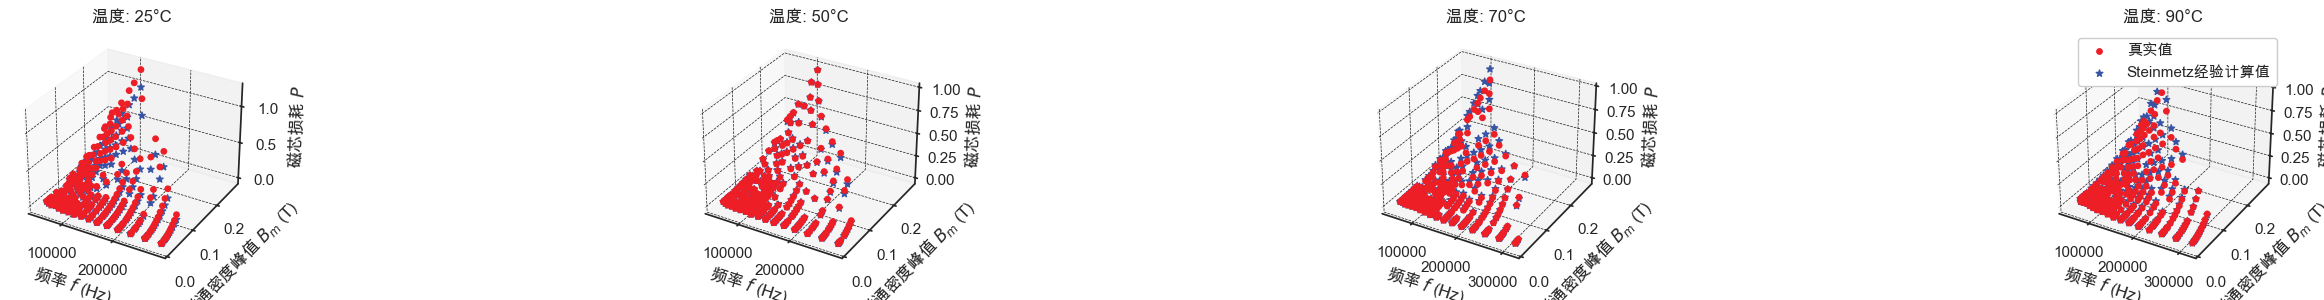

In [5]:
# %matplotlib qt5
fig, axs = plt.subplots(1, 4, figsize=(30, 3),
                        subplot_kw={'projection': '3d'})
temperatures = [25, 50, 70, 90]

for i, temp in enumerate(temperatures):
    ax = axs[i]
    df_temp = df[df['temp'] == temp]
    # plot true values
    ax.scatter(df_temp['freq'], df_temp['flux_density_max'], df_temp['core_loss'],
               c='#ed1e25', label='真实值', marker='o', s=15, alpha=1)
    # plot Steinmetz equation predictions
    ax.scatter(df_temp['freq'], df_temp['flux_density_max'], df_temp['core_loss_steinmetz'],
               c='#3753a4', label='Steinmetz经验计算值', marker='*', s=25, alpha=1)
    print(temp,
          (df_temp['core_loss'] - df_temp['core_loss_steinmetz']).mean(),
          (df_temp['core_loss'] - df_temp['core_loss_steinmetz']).std()
          )
    ax.set_xlabel('频率 $f$ (Hz)')
    ax.set_ylabel('磁通密度峰值 $B_{m}$ (T)')
    ax.set_zlabel('磁芯损耗 $P$')
    ax.set_title(f'温度: {temp}°C')
plt.legend()
plt.tight_layout()
plt.show()

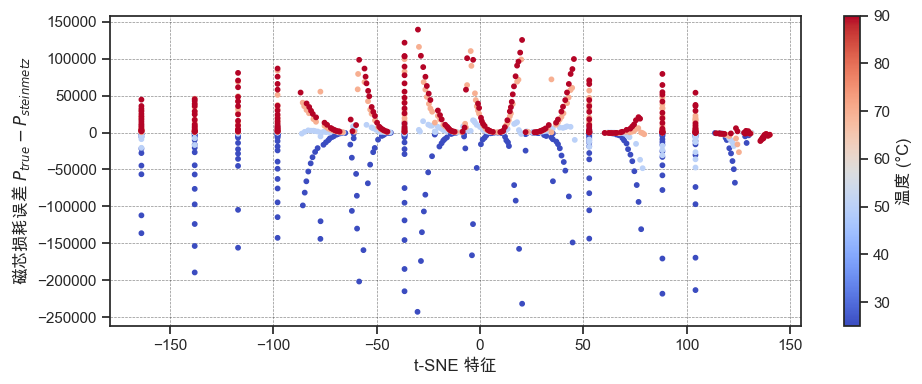

In [6]:
# t-sne
from sklearn.manifold import TSNE

features = df[['freq', 'flux_density_max']].values
tsne = TSNE(n_components=1, random_state=42)
tsne_features = tsne.fit_transform(features)
df['tsne'] = tsne_features
fig, ax = plt.subplots(figsize=(10, 4))
plt.scatter(df['tsne'], df['core_loss_steinmetz'] - df['core_loss'],
            c=df['temp'], cmap='coolwarm', s=10)
plt.colorbar(label='温度 (°C)')
plt.xlabel('t-SNE 特征')
plt.ylabel('磁芯损耗误差 $P_{true} - P_{steinmetz}$')
plt.tight_layout()
plt.savefig('figures/p2-2d-Steinmetzse-tsne.pdf', bbox_inches='tight')

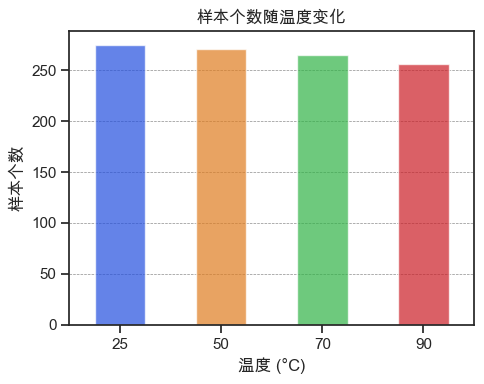

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.barplot(x=df['temp'].unique(),
            y=df['temp'].value_counts(), width=.5, ax=ax, alpha=0.7)
ax.set_ylabel("样本个数")
ax.set_xlabel("温度 (°C)")
ax.set_title("样本个数随温度变化")
plt.tight_layout()
plt.savefig('figures/p2-Steinmetzse-analysis(1).pdf', bbox_inches='tight')

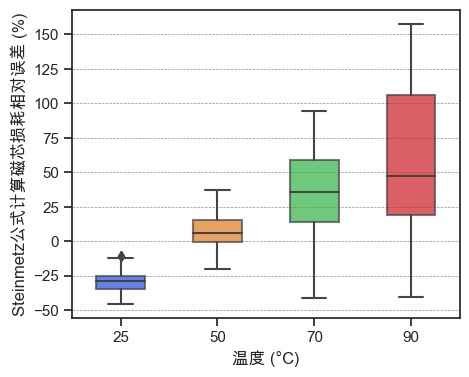

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
df['relative_error'] = ((df['core_loss_steinmetz'] - df['core_loss']) / df['core_loss']) * 100
sns.boxplot(data=df,
            x="temp",
            y="relative_error",
            width=.5, ax=ax,
            boxprops=dict(alpha=.7))
ax.set_ylabel("Steinmetz公式计算磁芯损耗相对误差 (%)")
ax.set_xlabel("温度 (°C)")
plt.savefig('figures/p2-Steinmetzse-analysis(2).pdf', bbox_inches='tight')

## 尝试: 参数拟合

In [31]:
import sympy as sp
from sympy import symbols, exp, log, latex
from sympy.utilities.lambdify import lambdify
from sklearn.metrics import r2_score

freq, flux_density_max, temp = symbols('f B_m T')
k, alpha, beta, c, d, k1, k2, c1, c2 = symbols('k alpha beta c d k1 k2 c1 c2')

def get_numerical_functions(function_definitions):
    numerical_functions = {}
    for name, expr, params in function_definitions:
        # Create a lambda function for numerical computation
        func_num = lambdify(
            (freq, flux_density_max, temp, *params),
            expr,
            modules=['numpy']
        )

        # Define a wrapper function for curve_fit
        def func_wrapper(xdata, *args, func_num=func_num):
            freq_data, flux_density_max_data, temp_data = xdata
            return func_num(freq_data, flux_density_max_data, temp_data, *args)
        numerical_functions[name] = (func_wrapper, params)

    return numerical_functions


function_definitions = [
    ('Steinmetz', k * freq**alpha * flux_density_max**beta + 0 * temp, [k, alpha, beta]),
    ('Exponential', k * freq**alpha * flux_density_max**beta * exp(c * temp), [k, alpha, beta, c]),
    ('Logarithmic', k * freq**alpha * flux_density_max**beta * log(1 + c * temp), [k, alpha, beta, c]),
    ('Linear', k * freq**alpha * flux_density_max**beta * (c * temp), [k, alpha, beta, c]),
    ('Power', k * freq**alpha * flux_density_max**beta * (1 + c1 * temp + c2 * temp**2), [k, alpha, beta, c1, c2]),
    ('Reciprocal', k * freq**alpha * flux_density_max**beta * (1 / temp)**c, [k, alpha, beta, c]),
    ('Sigmoid', k * freq**alpha * flux_density_max**beta / (1 + exp(-(c * temp + d))), [k, alpha, beta, c, d]),
]

numerical_functions = get_numerical_functions(function_definitions)

Steinmetz equation: $P = 1.49976107801975 \cdot B_{m}^{2.4712537053616} \cdot f^{1.42963345746347}$

Exponential equation: $P = 1.85009858681875 \cdot B_{m}^{2.43636664157452} \cdot f^{1.44704642602198} \cdot e^{- 0.00824493400543949 \cdot T}$

Logarithmic equation: $P = 0.00402725962013443 \cdot B_{m}^{2.47151043472253} \cdot f^{1.42958536258101} \cdot \log{\left(1.31623203318816 \cdot 10^{160} \cdot T + 1 \right)}$

Linear equation: $P = 0.00730286699285473 \cdot B_{m}^{2.61724078198739} \cdot T \cdot f^{1.53676605702572}$

Power equation: $P = 1.71682873675338 \cdot B_{m}^{2.45092395402538} \cdot f^{1.46674002739408} \cdot \left(6.97043168176094 \cdot 10^{-5} \cdot T^{2} - 0.0124086673784994 \cdot T + 1\right)$

Reciprocal equation: $P = 4.73838274395372 \cdot B_{m}^{2.44851471264968} \cdot f^{1.46348395958419} \cdot \left(\frac{1}{T}\right)^{0.401756830441125}$

Sigmoid equation: $P = \frac{1.49974533785926 \cdot B_{m}^{2.47125391023563} \cdot f^{1.42963438380578}}{1 + 0.3678794411

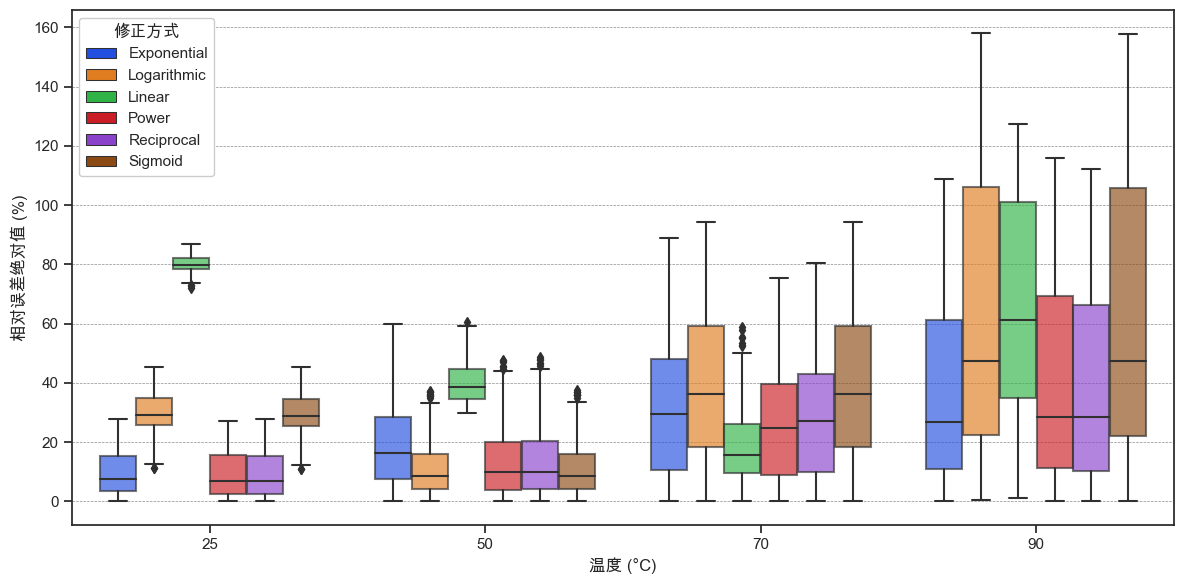

In [33]:
xdata = df[['freq', 'flux_density_max', 'temp']].values.T
ydata = df['core_loss'].values

results = {}
popt_values = {}
r2_scores = {}

for name, (func, params) in numerical_functions.items():
    try:
        xxdata = xdata
        p0 = [1.0] * len(params)
        popt, _ = curve_fit(func, xxdata, ydata, p0=p0, maxfev=10000)
        popt_values[name] = popt
        df[f'core_loss_{name.lower()}'] = func(xxdata, *popt)
        df[f'relative_error_{name.lower()}'] = (np.abs(df['core_loss'] - df[f'core_loss_{name.lower()}']) / df['core_loss']) * 100
        
        # Calculate R^2 score
        r2 = r2_score(ydata, df[f'core_loss_{name.lower()}'])
        df[f'eval_method_{name.lower()}'] = r2
        r2_scores[name] = r2
    except Exception as e:
        print(f"Failed to fit {name} function: {str(e)}")
        
for name, (expr, params) in zip(numerical_functions.keys(), [item[1:] for item in function_definitions]):
    popt = popt_values.get(name)
    if popt is not None:
        # Create a dictionary of parameter substitutions
        param_subs = dict(zip(params, popt))
        # Substitute numerical values into the symbolic expression
        expr_subs = expr.subs(param_subs)
        # Generate LaTeX expression
        latex_expr = latex(expr_subs, mul_symbol='dot')
        print(f"{name} equation: $P = {latex_expr}$\n")
        
# Print R^2 scores
for name, r2 in r2_scores.items():
    print(f"R^2 score for {name} function: {r2}")
    
# create a new dataframe for plotting
plot_df = pd.DataFrame()
for name, (func, params) in numerical_functions.items():
    if name == 'Steinmetz':
        continue
    temp_df = df[['temp', f'relative_error_{name.lower()}', f'eval_method_{name.lower()}']].copy()
    temp_df['Function'] = name
    temp_df.rename(columns={f'relative_error_{name.lower()}': 'Relative Error', f'eval_method_{name.lower()}': 'R2'}, inplace=True)
    plot_df = pd.concat([plot_df, temp_df], ignore_index=True)

# plot boxplot with hue as different functions
plt.figure(figsize=(12, 6))
sns.boxplot(data=plot_df, x='temp', y='Relative Error', hue='Function', boxprops=dict(alpha=.65))
plt.ylabel("相对误差绝对值 (%)")
plt.xlabel("温度 (°C)")
plt.legend(title='修正方式')
plt.tight_layout()
plt.savefig('figures/p2-modified-fit.pdf', bbox_inches='tight')

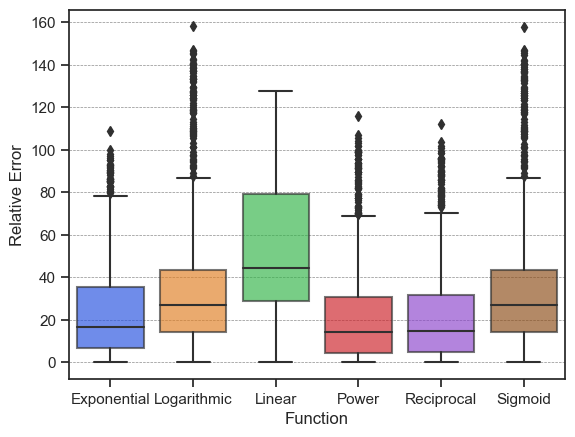

In [42]:
sns.boxplot(data=plot_df, x='Function', y='Relative Error', boxprops=dict(alpha=.65))
plt.savefig('figures/p2-modified-fit-small.pdf', bbox_inches='tight')

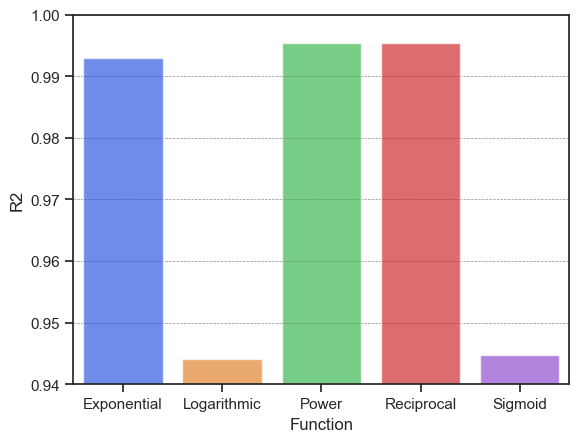

In [43]:
sns.barplot(data=plot_df[plot_df['Function'] != 'Linear'], x='Function', y='R2', alpha=.65)
plt.ylim(0.94, 1)
plt.savefig('figures/p2-modified-fit-r2.pdf', bbox_inches='tight')